In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')

347 total WT RuBisCOs
286 total unique species
200 RuBisCOs with all core kinetic data measured


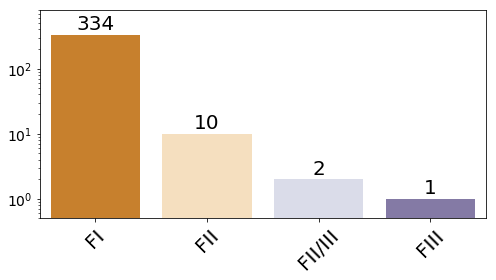

In [4]:
# Breakdown of data by taxonomy and isoform
isoform_counts = raw_kin_df.isoform.value_counts()

groups = {'1': 'FI', 
          '2': 'FII',
          '2_3': 'FII/III', 
          '3': 'FIII'}

fig = plt.figure(figsize=(7,4))

plt.yscale('log')
seaborn.barplot(y=isoform_counts, x=isoform_counts.index, palette='PuOr')
plt.xticks()

for i, (label, count) in enumerate(isoform_counts.iteritems()):
    plt.text(i, 1.2*count, str(count), ha='center', fontsize=20)

plt.ylim(0.5, 800)
plt.ylabel('', fontsize=18)
plt.yticks(fontsize=14)


xticks = [groups[i] for i in isoform_counts.index]
plt.xticks(np.arange(isoform_counts.size), xticks, fontsize=20, rotation=45, ha='center')
plt.tight_layout()

plt.savefig('fig2/fig2_isoform_counts.svg')
plt.savefig('fig2/fig2_isoform_counts.png', dpi=600)

plt.show()

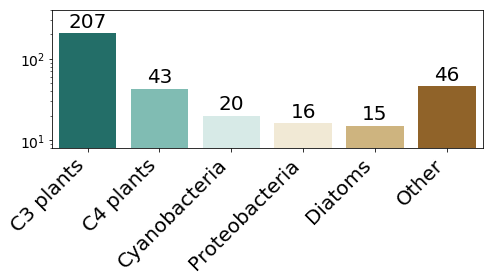

In [5]:
taxa_counts = raw_kin_df.taxonomy.value_counts()

fig = plt.figure(figsize=(7,4))

# Count the proteobacteria together
proteos = ['Alphaproteobacteria', 'Betaproteobacteria', 'Gammaproteobacteria']
proteo_counts = taxa_counts[proteos].sum()
rest_counts = taxa_counts.sum() - taxa_counts[:4].sum() - proteo_counts

ys = np.array(taxa_counts[:4].values.tolist() + [proteo_counts])
labels = np.array(taxa_counts[:4].index.tolist() + ['Proteobacteria'])

# Reorder to be sorted
ys_order = np.argsort(ys)[::-1]
ys = ys[ys_order].tolist() + [rest_counts]
labels = labels[ys_order].tolist() + ['Other']

plt.yscale('log')
seaborn.barplot(y=ys, x=labels, palette='BrBG_r')

for i, (label, count) in enumerate(zip(labels, ys)):
    plt.text(i, 1.2*count, str(count), ha='center', fontsize=20)

plt.ylim(8, 400)
plt.xticks(fontsize=20, rotation=45, ha='right')
plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('fig2/fig2_taxonomy_counts.svg')
plt.savefig('fig2/fig2_taxonomy_counts.png', dpi=600)

plt.show()

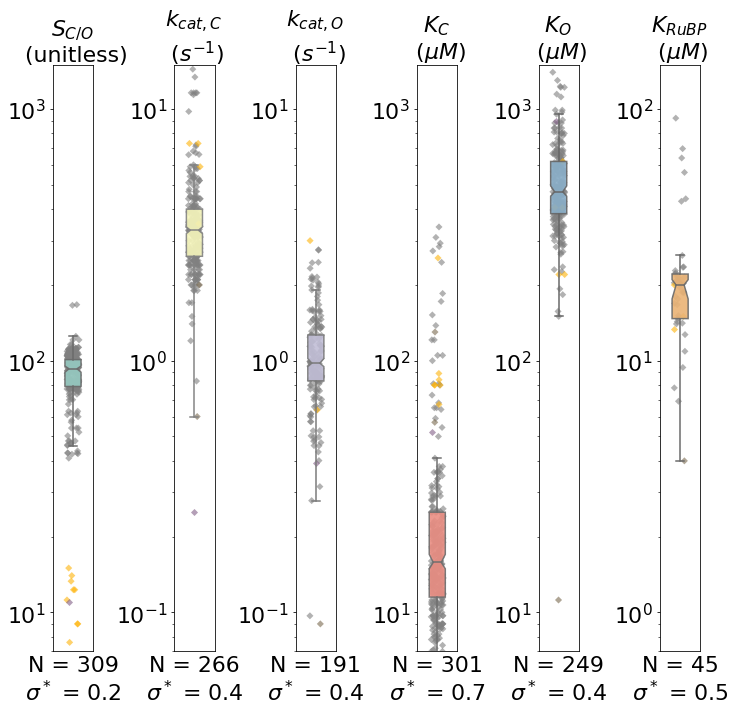

In [6]:
# Description of the data set
figure = plt.figure(figsize=(10,10))

cols = ['S', 'vC', 'vO', 'KC', 'KO', 'KRuBP']
titles = {'S': '$S_{C/O}$', 'vC': '$k_{cat,C}$', 'KC':
          '$K_C$', 'vO': '$k_{cat,O}$', 'KO': '$K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless', 'vC': '$s^{-1}$', 'KC':
         '$\mu M$', 'vO': '$s^{-1}$', 'KO': '$\mu M$',
         'KRuBP': '$\mu M$'}
ylim = {'S': (7, 1500),
        'vC': (0.7e-1, 1.5e1),
        'vO':(0.7e-1, 1.5e1),
        'KC': (7, 1.5e3),
        'KO': (7, 1.5e3),
        'KRuBP': (0.7, 1.5e2)}

nsub = len(cols)
pal = seaborn.color_palette('Set3')

for i, c in enumerate(cols):
    mask = raw_kin_df[c].notnull()
    vals = raw_kin_df[mask][c]
    
    ax = plt.subplot(1, nsub, i+1)
    plt.yscale('log')
    sigma_star = None

    for j, (group, gdf) in enumerate(raw_kin_df.groupby('isoform')):
        color = named_colors[j]
        if group == '1':
            color = 'grey'
            sigma_star = np.nanstd(np.log(gdf[c]))
            
        seaborn.stripplot(y=gdf[c], color=color, jitter=0.15, size=5, marker='D', alpha=0.6, zorder=-1)
        
    seaborn.boxplot(y=raw_kin_df[c], color=pal[i], width=0.4, notch=True, bootstrap=1000, zorder=10,
                    boxprops=dict(alpha=.9), showfliers=False)
            
    nvals = raw_kin_df[c].notnull().sum()
    xlabel = 'N = %d\n$\sigma^*$ = %.1f' % (nvals, sigma_star)

    plt.ylim(*ylim[c])
    plt.xticks([])
    plt.yticks(fontsize=22)
    plt.ylabel('')
    plt.xlabel(xlabel, fontsize=22, ha='center')
    
    title = '%s \n (%s)' % (titles[c], units[c])
    plt.title(title, fontsize=22)
    
plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.savefig('fig2/fig2_data_summary.svg')
plt.savefig('fig2/fig2_data_summary.png', dpi=600, bbox_inches='tight', pad_inches=0.2)

plt.show()

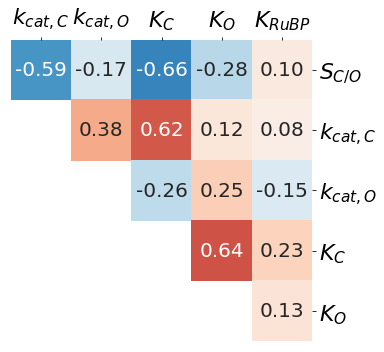

In [7]:
# Summary of correlations among FI Rubiscos
cols = ['S', 'vC', 'vO', 'KC', 'KO', 'KRuBP']
titles = {'S': '$S_{C/O}$', 'vC': '$k_{cat,C}$', 'KC':
          '$K_C$', 'vO': '$k_{cat,O}$', 'KO': '$K_O$',
          'KRuBP': '$K_{RuBP}$'}
ticks = [titles[c] for c in cols]

# Can calculate correlation matrix with pandas, but it doesn't give pvals. 
all_FI = raw_kin_df[raw_kin_df.isoform == '1']
corrM = np.log10(all_FI[cols]).corr()
corrM += np.diag([np.NaN] * len(cols))
corrM = np.triu(corrM)
corrM[np.where(corrM == 0)] = np.NaN

        
figure = plt.figure(figsize=(7,5))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

seaborn.heatmap(corrM[:-1,1:], square=True, center=0, 
                cmap="RdBu_r", vmin=-1, vmax=1,
                annot=True, cbar=False, annot_kws={'fontsize': 20}, fmt='.2f')

xax = figure.get_axes()[0]
xax.xaxis.tick_top()
xax.yaxis.tick_right()

tickrange = np.arange(len(cols)-1) + 0.5
plt.xticks(tickrange, ticks[1:], fontsize=22)
plt.yticks(tickrange, ticks[:-1], fontsize=22, rotation='horizontal')
#plt.tick_params(
#    axis='both',       # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    top=False,         # ticks along the top edge are off
#    right=False)       # ticks along the right edge are off

plt.tight_layout()
plt.savefig('fig2/fig2_FI_corr.svg')
plt.savefig('fig2/fig2_FI_corr.png', dpi=600)

plt.show()